In [190]:
import json
import pandas as pd

from math import log10, log2
from plotnine import *
from os import environ
from os.path import join, dirname
from os import makedirs
import os
import numpy as np
from metagenscope.remote_utils import download_s3_file
#from metagenscope.modules.parse_utils import parse_generic
from capalyzer.packet_parser.diversity_metrics import shannon_entropy
from sklearn.decomposition import PCA
from pangea_api import (
    Knex,
    User,
    Organization,
    SampleAnalysisResultField,
)

knex = Knex('https://pangea.gimmebio.com')
org = Organization(knex, 'Mason Lab').get()
grp = org.sample_group('PathoMAP').get()

In [2]:
def parse_taxa_report(report: SampleAnalysisResultField) -> dict:
    """Return a dict of taxa_name to relative abundance."""
    local_path = report.download_file()
    out, abundance_sum = {}, 0
    with open(local_path) as taxa_file:
        for line_num, line in enumerate(taxa_file):
            line = line.strip()
            tkns = line.split('\t')
            if not line or len(tkns) < 2:
                continue
            if len(tkns) == 2:
                out[tkns[0]] = float(tkns[1])
                abundance_sum += float(tkns[1])
            else:
                if line_num == 0:
                    continue
                out[tkns[1]] = float(tkns[3])
                abundance_sum += float(tkns[3])
    out = {k: v for k, v in out.items() if 's__' in k and 't__' not in k}
    return out

taxa = {}
for i, sample in enumerate(grp.get_samples()):
    if i and (i % 100) == 0:
        print(f'{i} done')
    try:
        ar = sample.analysis_result('cap2::kraken2').get()
        arf = ar.field('report').get() 
        report = parse_taxa_report(arf)
        taxa[sample.name] = report
    except:
        pass
taxa = pd.DataFrame.from_dict(taxa, orient='index')
taxa

In [8]:
def parse_abund_report(report: SampleAnalysisResultField) -> dict:
    """Return a dict of path_name to relative abundance."""
    local_path = report.download_file()
    out, abundance_sum = {}, 0
    with open(local_path) as taxa_file:
        taxa_file.readline()
        for line_num, line in enumerate(taxa_file):
            line = line.strip()
            tkns = line.split('\t')
            if not line or len(tkns) < 2:
                continue
            if len(tkns) == 2:
                out[tkns[0]] = float(tkns[1])
                abundance_sum += float(tkns[1])
            else:
                if line_num == 0:
                    continue
                out[tkns[1]] = float(tkns[3])
                abundance_sum += float(tkns[3])
    return out

paths = {}
for i, sample in enumerate(grp.get_samples()):
    if i and (i % 200) == 0:
        print(f'{i} done')
    try:
        ar = sample.analysis_result('cap1::humann2_functional_profiling').get()
        arf = ar.field('path_abunds').get() 
        report = parse_abund_report(arf)
        paths[sample.name] = report
    except:
        pass
paths = pd.DataFrame.from_dict(paths, orient='index')
paths

200 done
400 done
600 done
800 done
1000 done
1200 done
1400 done


,UNMAPPED,UNINTEGRATED,UNINTEGRATED|unclassified,PWY-7220: adenosine deoxyribonucleotides de novo biosynthesis II,PWY-7220: adenosine deoxyribonucleotides de novo biosynthesis II|unclassified,PWY-7222: guanosine deoxyribonucleotides de novo biosynthesis II,PWY-7222: guanosine deoxyribonucleotides de novo biosynthesis II|unclassified,PWY-7228: superpathway of guanosine nucleotides de novo biosynthesis I,PWY-7228: superpathway of guanosine nucleotides de novo biosynthesis I|unclassified,PWY-6125: superpathway of guanosine nucleotides de novo biosynthesis II,...,"PWY-6383: mono-trans, poly-cis decaprenyl phosphate biosynthesis","PWY-6383: mono-trans, poly-cis decaprenyl phosphate biosynthesis|unclassified",PWY-4221: pantothenate and coenzyme A biosynthesis II (plants),PWY-4221: pantothenate and coenzyme A biosynthesis II (plants)|unclassified,PWY-3941: &beta;-alanine biosynthesis II,PWY-3941: &beta;-alanine biosynthesis II|unclassified,PWY-7153: grixazone biosynthesis,PWY-7153: grixazone biosynthesis|unclassified,PWY-5940: streptomycin biosynthesis,PWY-5940: streptomycin biosynthesis|unclassified
PATHOMAP_AB001,0.0,4.383489e+04,4.383489e+04,123.470749,123.470749,123.470749,123.470749,61.063085,61.063085,56.224669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_AB002,0.0,8.681896e+04,8.681896e+04,114.324894,114.324894,114.324894,114.324894,68.154752,68.154752,52.566807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_AB003,0.0,8.776565e+04,8.776565e+04,108.816084,108.816084,108.816084,108.816084,87.481122,87.481122,71.850785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_AB004,0.0,3.682775e+04,3.682775e+04,62.876422,62.876422,62.876422,62.876422,57.434084,57.434084,46.785834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_AB005,0.0,5.520407e+04,5.520407e+04,57.130990,57.130990,57.130990,57.130990,50.243773,50.243773,45.461819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,0.0,8.420567e+05,8.420567e+05,707.205489,707.205489,707.205489,707.205489,557.868966,557.868966,408.723964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_P01612,0.0,3.323179e+05,3.323179e+05,127.242896,127.242896,127.242896,127.242896,132.875366,132.875366,125.602616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_P01613,0.0,5.856335e+04,5.856335e+04,33.935023,33.935023,33.935023,33.935023,37.938953,37.938953,37.224515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATHOMAP_PosControl_NARG1,0.0,2.051970e+06,2.051970e+06,1469.777753,1469.777753,1469.777753,1469.777753,1455.389926,1455.389926,1409.287464,...,NaN,NaN,NaN,NaN,NaN,NaN,40.909039,40.909039,6.258959,6.258959


In [12]:
paths = paths[[col for col in paths.columns if 'unclassified' not in col][2:]].fillna(0)

In [13]:
paths

,PWY-7220: adenosine deoxyribonucleotides de novo biosynthesis II,PWY-7222: guanosine deoxyribonucleotides de novo biosynthesis II,PWY-7228: superpathway of guanosine nucleotides de novo biosynthesis I,PWY-6125: superpathway of guanosine nucleotides de novo biosynthesis II,PWY-7208: superpathway of pyrimidine nucleobases salvage,PWY-7184: pyrimidine deoxyribonucleotides de novo biosynthesis I,PWY-6703: preQ0 biosynthesis,PWY-7221: guanosine ribonucleotides de novo biosynthesis,PWY-6126: superpathway of adenosine nucleotides de novo biosynthesis II,PWY-7219: adenosine ribonucleotides de novo biosynthesis,...,PWY-7456: mannan degradation,PWY-6728: methylaspartate cycle,PWY-5328: superpathway of L-methionine salvage and degradation,PWY-5531: chlorophyllide a biosynthesis II (anaerobic),"PWY-7159: chlorophyllide a biosynthesis III (aerobic, light independent)","PWY-6383: mono-trans, poly-cis decaprenyl phosphate biosynthesis",PWY-4221: pantothenate and coenzyme A biosynthesis II (plants),PWY-3941: &beta;-alanine biosynthesis II,PWY-7153: grixazone biosynthesis,PWY-5940: streptomycin biosynthesis
PATHOMAP_AB001,123.470749,123.470749,61.063085,56.224669,52.765657,51.045556,51.032034,48.532462,47.817269,47.338142,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB002,114.324894,114.324894,68.154752,52.566807,54.458629,57.616825,44.906360,55.815612,57.381871,71.912246,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB003,108.816084,108.816084,87.481122,71.850785,62.180150,70.745479,47.146627,77.432217,68.992899,73.967528,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB004,62.876422,62.876422,57.434084,46.785834,52.348837,49.573269,12.985377,53.344810,16.566670,49.107848,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB005,57.130990,57.130990,50.243773,45.461819,39.440316,44.335803,24.440200,45.288211,40.652516,41.728397,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,707.205489,707.205489,557.868966,408.723964,504.205724,512.651922,452.040149,483.201322,585.141421,558.283505,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_P01612,127.242896,127.242896,132.875366,125.602616,76.495776,151.163658,80.485070,129.603634,113.466654,147.592612,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_P01613,33.935023,33.935023,37.938953,37.224515,26.081282,34.970563,17.637960,40.371915,27.427593,35.364757,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_PosControl_NARG1,1469.777753,1469.777753,1455.389926,1409.287464,1251.244096,627.574750,472.296324,1414.129408,933.606964,1171.589154,...,0.0,0.0,43.538433,0.0,0.0,0.0,0.0,0.0,40.909039,6.258959


In [30]:
t = (taxa.T / taxa.sum(axis=1)).T
t = t.fillna(0)
t.columns = [col.split('s__')[1] for col in t.columns]

def run_pca_norm(tbl, n_comp, zero_thresh):
    pca = PCA(n_components=n_comp)
    tbl_pca = pca.fit_transform(tbl)
    tbl_rev = pd.DataFrame(pca.inverse_transform(tbl_pca))
    tbl_rev.index = tbl.index
    tbl_rev.columns = tbl.columns
    tbl_rev = tbl_rev.applymap(lambda el: el if el > zero_thresh else 0)
    return tbl_rev

t = run_pca(t, 1000, 1 / 1000000)
t = t.loc[:,t.sum() > 0]
t

,Pseudomonas stutzeri,Pseudomonas xanthomarina,Pseudomonas balearica,Pseudomonas luteola,Pseudomonas saudiphocaensis,Pseudomonas sp. OIL-1,Pseudomonas sp. gcc21,Pseudomonas sp. S-6-2,Pseudomonas sp. CC6-YY-74,Pseudomonas sp. R2A2,...,Acidianus bottle-shaped virus,Streptococcus virus 9871,Thermus virus P74-26,Pseudomonas virus 141,Klebsiella virus myPSH1235,Shigella phage HRP29,Enterobacter virus E3,Porcine type-C oncovirus,Cacao swollen shoot Ghana M virus,Torque teno midi virus 2
PATHOMAP_AB001,0.227791,0.043245,0.006460,0.000757,0.071781,0.004774,0.003096,0.002480,0.002300,0.001795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_AB002,0.016314,0.002499,0.000436,0.000073,0.000490,0.000054,0.000035,0.000031,0.000181,0.000201,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_AB003,0.000323,0.000009,0.000019,0.000000,0.000014,0.000010,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_AB004,0.011500,0.000679,0.001047,0.000204,0.000829,0.000437,0.000743,0.000941,0.002774,0.000276,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_AB005,0.137398,0.002391,0.002929,0.000062,0.014639,0.000316,0.000290,0.000486,0.002810,0.001242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,0.012421,0.000047,0.000089,0.006694,0.000052,0.000020,0.000020,0.000026,0.000088,0.000070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_P01612,0.001393,0.000060,0.000084,0.000166,0.000028,0.000010,0.000013,0.000003,0.000040,0.000013,...,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PATHOMAP_P01613,0.010979,0.001078,0.000309,0.000317,0.000326,0.000113,0.000043,0.000301,0.000113,0.000100,...,0.000000,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000009
PATHOMAP_PosControl_NARG1,0.000012,0.000001,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:

t_pca = PCA(n_components=10).fit_transform(t)
t_pca = pd.DataFrame(t_pca)
t_pca.index = t.index
t_pca.columns = [f'Taxa-PC-{i + 1}' for i in t_pca.columns]

t_pca

,Taxa-PC-1,Taxa-PC-2,Taxa-PC-3,Taxa-PC-4,Taxa-PC-5,Taxa-PC-6,Taxa-PC-7,Taxa-PC-8,Taxa-PC-9,Taxa-PC-10
PATHOMAP_AB001,-0.014397,-0.007971,-0.035530,-0.023747,-0.034531,-0.015291,-0.023077,-0.006539,-0.020691,0.002764
PATHOMAP_AB002,-0.219318,-0.067391,-0.041906,-0.034811,-0.042896,-0.013127,-0.023817,-0.006604,-0.013057,0.010670
PATHOMAP_AB003,-0.242646,-0.076941,-0.054832,-0.045711,-0.070846,-0.023787,-0.043163,-0.041907,-0.001257,-0.023941
PATHOMAP_AB004,-0.222930,-0.066152,-0.040424,-0.033313,-0.040658,-0.012450,-0.021884,-0.004072,-0.013905,0.005789
PATHOMAP_AB005,-0.096995,-0.053449,-0.036704,-0.026902,-0.033738,-0.012170,-0.018098,-0.003962,-0.009212,0.006837
...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,-0.265187,0.326661,-0.021323,-0.006950,-0.027391,-0.006467,-0.033065,0.000594,-0.019660,-0.000978
PATHOMAP_P01612,-0.258620,-0.101506,-0.178429,0.362929,0.167790,0.044436,0.008477,-0.011186,-0.000278,0.007241
PATHOMAP_P01613,-0.233918,-0.074427,-0.070608,0.033527,-0.022176,-0.010827,-0.049025,0.013265,0.127818,-0.049706
PATHOMAP_PosControl_NARG1,-0.234159,-0.067029,-0.039980,-0.034666,-0.040442,-0.012307,-0.020834,-0.007917,-0.008543,0.009110


In [51]:
paths

,PWY-7220: adenosine deoxyribonucleotides de novo biosynthesis II,PWY-7222: guanosine deoxyribonucleotides de novo biosynthesis II,PWY-7228: superpathway of guanosine nucleotides de novo biosynthesis I,PWY-6125: superpathway of guanosine nucleotides de novo biosynthesis II,PWY-7208: superpathway of pyrimidine nucleobases salvage,PWY-7184: pyrimidine deoxyribonucleotides de novo biosynthesis I,PWY-6703: preQ0 biosynthesis,PWY-7221: guanosine ribonucleotides de novo biosynthesis,PWY-6126: superpathway of adenosine nucleotides de novo biosynthesis II,PWY-7219: adenosine ribonucleotides de novo biosynthesis,...,PWY-7456: mannan degradation,PWY-6728: methylaspartate cycle,PWY-5328: superpathway of L-methionine salvage and degradation,PWY-5531: chlorophyllide a biosynthesis II (anaerobic),"PWY-7159: chlorophyllide a biosynthesis III (aerobic, light independent)","PWY-6383: mono-trans, poly-cis decaprenyl phosphate biosynthesis",PWY-4221: pantothenate and coenzyme A biosynthesis II (plants),PWY-3941: &beta;-alanine biosynthesis II,PWY-7153: grixazone biosynthesis,PWY-5940: streptomycin biosynthesis
PATHOMAP_AB001,123.470749,123.470749,61.063085,56.224669,52.765657,51.045556,51.032034,48.532462,47.817269,47.338142,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB002,114.324894,114.324894,68.154752,52.566807,54.458629,57.616825,44.906360,55.815612,57.381871,71.912246,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB003,108.816084,108.816084,87.481122,71.850785,62.180150,70.745479,47.146627,77.432217,68.992899,73.967528,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB004,62.876422,62.876422,57.434084,46.785834,52.348837,49.573269,12.985377,53.344810,16.566670,49.107848,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_AB005,57.130990,57.130990,50.243773,45.461819,39.440316,44.335803,24.440200,45.288211,40.652516,41.728397,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,707.205489,707.205489,557.868966,408.723964,504.205724,512.651922,452.040149,483.201322,585.141421,558.283505,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_P01612,127.242896,127.242896,132.875366,125.602616,76.495776,151.163658,80.485070,129.603634,113.466654,147.592612,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_P01613,33.935023,33.935023,37.938953,37.224515,26.081282,34.970563,17.637960,40.371915,27.427593,35.364757,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
PATHOMAP_PosControl_NARG1,1469.777753,1469.777753,1455.389926,1409.287464,1251.244096,627.574750,472.296324,1414.129408,933.606964,1171.589154,...,0.0,0.0,43.538433,0.0,0.0,0.0,0.0,0.0,40.909039,6.258959


In [52]:
p = (paths.T / paths.sum(axis=1)).T
p = p.fillna(0)

p_pca = PCA(n_components=10).fit_transform(p)
p_pca = pd.DataFrame(p_pca)
p_pca.index = p.index
p_pca.columns = [f'Paths-PC-{i + 1}' for i in p_pca.columns]

p_pca

,Paths-PC-1,Paths-PC-2,Paths-PC-3,Paths-PC-4,Paths-PC-5,Paths-PC-6,Paths-PC-7,Paths-PC-8,Paths-PC-9,Paths-PC-10
PATHOMAP_AB001,0.009894,-0.042537,-0.000550,-0.011440,0.030878,-0.007835,-0.006311,-0.003451,0.001007,0.002449
PATHOMAP_AB002,-0.000955,0.006296,0.011070,-0.007660,0.004127,-0.006075,0.004006,0.000591,0.003931,-0.008849
PATHOMAP_AB003,0.004460,-0.012379,0.008372,0.009220,-0.003606,-0.004716,0.039646,-0.040897,-0.001434,-0.007151
PATHOMAP_AB004,0.008612,-0.023962,-0.007395,0.000241,0.020441,0.000409,-0.002106,-0.005636,-0.004129,-0.004660
PATHOMAP_AB005,0.000311,-0.011106,-0.010275,0.006668,0.009304,0.000609,-0.001947,-0.002197,-0.002153,-0.003886
...,...,...,...,...,...,...,...,...,...,...
PATHOMAP_P01611,-0.002625,0.002898,0.003065,0.010442,-0.001755,-0.005240,-0.001553,0.003347,0.004641,0.002301
PATHOMAP_P01612,0.005404,-0.017032,-0.002337,-0.003627,-0.023958,-0.007274,-0.003952,0.003935,-0.017653,-0.006891
PATHOMAP_P01613,0.002135,-0.011927,-0.004219,-0.000649,-0.016227,0.000233,-0.003956,0.001895,-0.019492,-0.001419
PATHOMAP_PosControl_NARG1,-0.005422,0.013894,0.012144,-0.005784,-0.003604,0.012096,0.005950,-0.002891,0.002967,0.006612


In [53]:
comb = pd.concat([t_pca, p_pca], axis=1)

corrs = comb.corr(method='spearman')
corrs = corrs.applymap(lambda x: x if x > 1e-6 else 0).applymap(lambda x: x if x < 1 else 0)

print(corrs.max().max())
corrs

0.4999016352793561


/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Taxa-PC-1,Taxa-PC-2,Taxa-PC-3,Taxa-PC-4,Taxa-PC-5,Taxa-PC-6,Taxa-PC-7,Taxa-PC-8,Taxa-PC-9,Taxa-PC-10,Paths-PC-1,Paths-PC-2,Paths-PC-3,Paths-PC-4,Paths-PC-5,Paths-PC-6,Paths-PC-7,Paths-PC-8,Paths-PC-9,Paths-PC-10
Taxa-PC-1,0.000000,0.416582,0.299061,0.166433,0.231225,0.034610,0.323615,0.230058,0.136979,0.000000,0.000000,0.000000,0.000000,0.000000,0.499902,0.311551,0.040723,0.003679,0.126778,0.124309
Taxa-PC-2,0.416582,0.000000,0.422958,0.165732,0.215939,0.186822,0.258760,0.175568,0.111681,0.000000,0.016368,0.000000,0.000000,0.386356,0.214178,0.000000,0.000000,0.175308,0.369025,0.397059
Taxa-PC-3,0.299061,0.422958,0.000000,0.199316,0.373800,0.000000,0.269333,0.290912,0.201395,0.000000,0.000000,0.250454,0.000000,0.256262,0.374075,0.000000,0.012628,0.114574,0.296395,0.090807
Taxa-PC-4,0.166433,0.165732,0.199316,0.000000,0.434854,0.199399,0.285171,0.028429,0.200602,0.039621,0.000000,0.082852,0.000000,0.000000,0.023531,0.000000,0.000000,0.186862,0.000000,0.120424
Taxa-PC-5,0.231225,0.215939,0.373800,0.434854,0.000000,0.337310,0.426495,0.273905,0.350009,0.018375,0.000000,0.065341,0.000000,0.073997,0.163754,0.000000,0.000000,0.127388,0.082754,0.199684
Taxa-PC-6,0.034610,0.186822,0.000000,0.199399,0.337310,0.000000,0.131214,0.016493,0.157477,0.096554,0.000000,0.154749,0.009791,0.000000,0.000000,0.000000,0.000000,0.154607,0.000000,0.116632
Taxa-PC-7,0.323615,0.258760,0.269333,0.285171,0.426495,0.131214,0.000000,0.110756,0.295347,0.000000,0.000000,0.276874,0.000000,0.043625,0.363916,0.000000,0.000000,0.087512,0.126512,0.003962
Taxa-PC-8,0.230058,0.175568,0.290912,0.028429,0.273905,0.016493,0.110756,0.000000,0.188864,0.093203,0.000000,0.043292,0.000000,0.009003,0.176875,0.000000,0.000000,0.318945,0.015163,0.112329
Taxa-PC-9,0.136979,0.111681,0.201395,0.200602,0.350009,0.157477,0.295347,0.188864,0.000000,0.000000,0.000000,0.122593,0.000000,0.000000,0.044523,0.000000,0.003388,0.120872,0.117188,0.110301
Taxa-PC-10,0.000000,0.000000,0.000000,0.039621,0.018375,0.096554,0.000000,0.093203,0.000000,0.000000,0.110024,0.000000,0.178164,0.000000,0.000000,0.044218,0.000000,0.241825,0.006231,0.000000


In [61]:
from umap import UMAP


def umap(mytbl, **kwargs):
    """Retrun a Pandas dataframe with UMAP, make a few basic default decisions."""
    metric = 'jaccard'
    if mytbl.shape[0] == mytbl.shape[1]:
        metric = 'precomputed'
    n_comp = kwargs.get('n_components', 2)
    umap_tbl = pd.DataFrame(UMAP(
        n_neighbors=kwargs.get('n_neighbors', min(100, int(mytbl.shape[0] / 4))),
        n_components=n_comp,
        metric=kwargs.get('metric', metric),
        random_state=kwargs.get('random_state', 42)
    ).fit_transform(mytbl))
    umap_tbl.index = mytbl.index
    col_pref = kwargs.get('col_prefix', '')
    umap_tbl = umap_tbl.rename(columns={i: f'{col_pref}C{i}' for i in range(n_comp)})
    return umap_tbl



In [114]:
comb = pd.concat([
    umap(p, n_components=1, col_prefix='PATHS-', n_neighbors=10, metric='manhattan'),
    umap(t, n_components=2, col_prefix='TAXA-', n_neighbors=10, metric='manhattan')
], axis=1)
comb

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,PATHS-C0,TAXA-C0,TAXA-C1
PATHOMAP_AB001,12.009221,1.039562,9.613977
PATHOMAP_AB002,1.160564,0.916583,5.153110
PATHOMAP_AB003,24.001398,-0.094980,3.233721
PATHOMAP_AB004,12.199080,1.811518,5.672012
PATHOMAP_AB005,10.992345,0.924495,9.143169
...,...,...,...
PATHOMAP_P01612,4.725038,1.232993,3.276647
PATHOMAP_P01613,5.583721,-1.307341,2.981276
PATHOMAP_PosControl_NARG1,-6.215152,-0.641970,4.331483
PATHOMAP_PosControl_NARG2,-6.200699,-0.641922,4.264479


/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 46 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


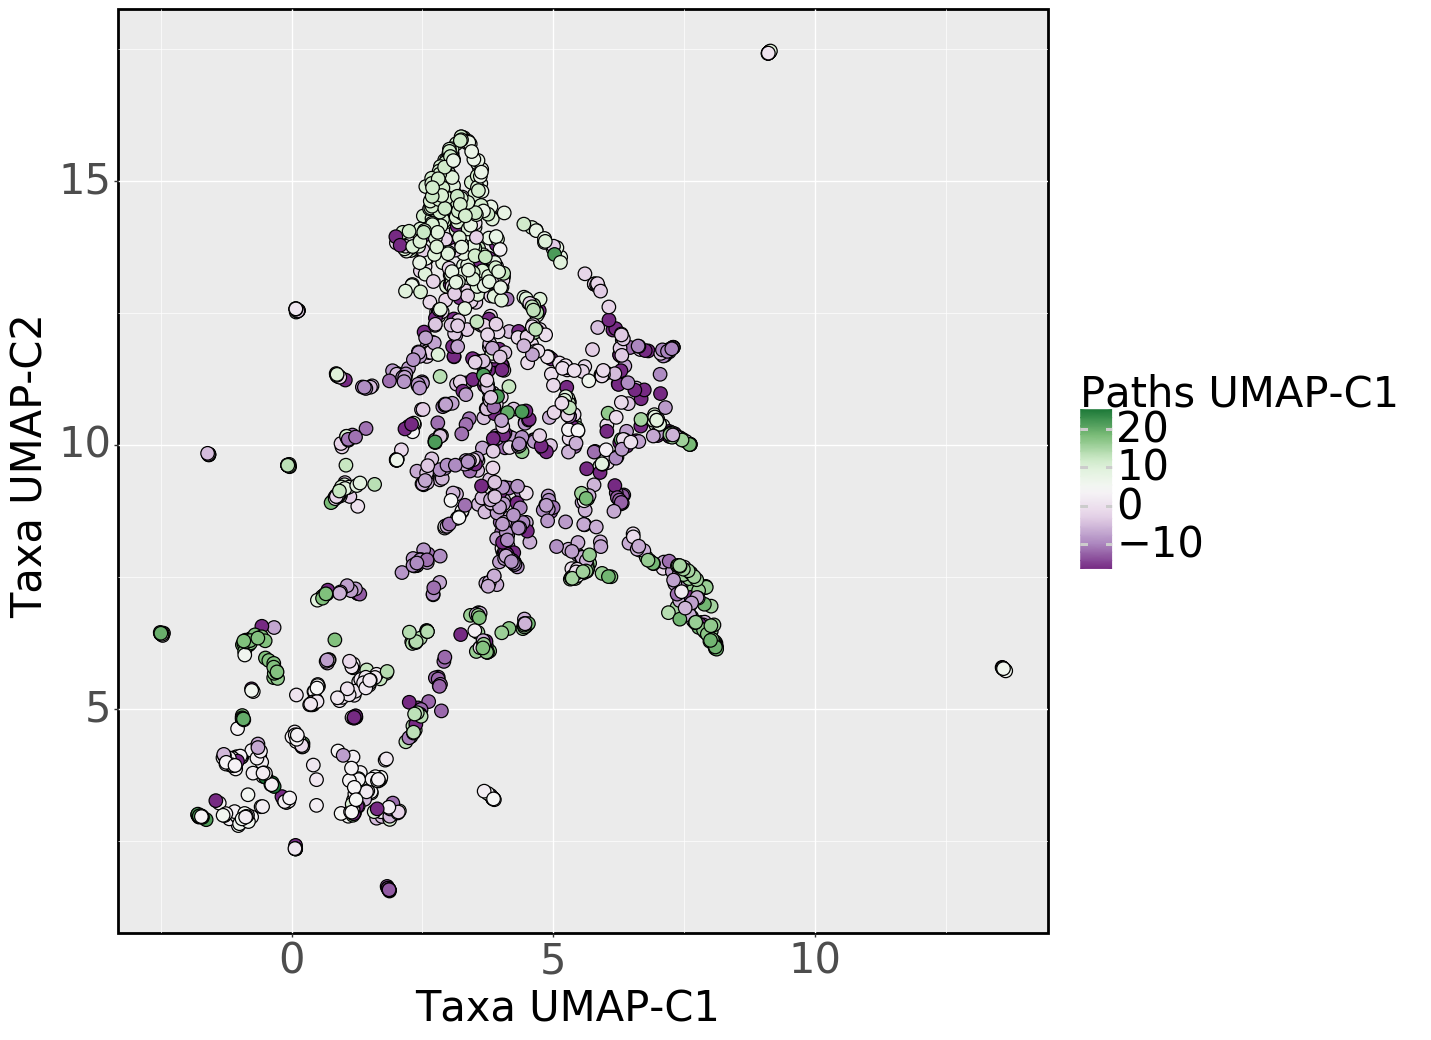

<ggplot: (8764547259540)>

In [115]:
def scatter(t, x, y, z):
    return (
        ggplot(t, aes(x=x, y=y, fill=z)) +
            geom_point(size=5, color='black') +
            #theme_minimal() +
            ylab(y) +
            xlab(x) +
            scale_fill_distiller(palette=2, type='div') +
            theme(
                text=element_text(size=30),
                figure_size=(12, 12),
                #legend_position='none',
                #axis_text_x=element_text(angle=90),
                panel_border=element_rect(colour="black", fill='none', size=2),
            )
    )

comb.columns = ['Paths UMAP-C1', 'Taxa UMAP-C1', 'Taxa UMAP-C2']
scatter(comb, 'Taxa UMAP-C1', 'Taxa UMAP-C2', 'Paths UMAP-C1')

In [117]:
def parse_ags_report(report: SampleAnalysisResultField) -> dict:
    """Return a dict of taxa_name to relative abundance."""
    local_path = report.download_file()
    with open(local_path) as f:
        for _ in range(10):
            f.readline()
        line = f.readline().split()[1]
        return float(line)

ags = {}
for i, sample in enumerate(grp.get_samples()):
    if i and (i % 100) == 0:
        print(f'{i} done')
    try:
        ar = sample.analysis_result('cap1::microbe_census').get()
        arf = ar.field('stats').get() 
        ags[sample.name] = parse_ags_report(arf)
    except:
        pass
ags = pd.DataFrame.from_dict(ags, orient='index')
ags

100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
1000 done
1100 done
1200 done
1300 done
1400 done
1500 done


,0
PATHOMAP_AB001,2.521356e+06
PATHOMAP_AB002,3.653614e+06
PATHOMAP_AB003,5.337981e+06
PATHOMAP_AB004,5.558052e+06
PATHOMAP_AB005,4.245577e+06
...,...
PATHOMAP_P01611,4.215869e+06
PATHOMAP_P01612,1.323510e+07
PATHOMAP_P01613,4.307745e+06
PATHOMAP_PosControl_NARG1,3.514341e+06


In [217]:
pca_comb = pd.concat([t_pca, p_pca, ags], axis=1)
pca_comb.columns = list(pca_comb.columns[:-1]) + ['ags']
corrs = pca_comb.corr(method='spearman')
corrs = corrs.applymap(lambda x: x if x > 1e-6 else 0).applymap(lambda x: x if x < 1 else 0)

print(corrs.max().max())
corrs

0.4999016352793561


/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Taxa-PC-1,Taxa-PC-2,Taxa-PC-3,Taxa-PC-4,Taxa-PC-5,Taxa-PC-6,Taxa-PC-7,Taxa-PC-8,Taxa-PC-9,Taxa-PC-10,...,Paths-PC-2,Paths-PC-3,Paths-PC-4,Paths-PC-5,Paths-PC-6,Paths-PC-7,Paths-PC-8,Paths-PC-9,Paths-PC-10,ags
Taxa-PC-1,0.000000,0.416582,0.299061,0.166433,0.231225,0.034610,0.323615,0.230058,0.136979,0.000000,...,0.000000,0.000000,0.000000,0.499902,0.311551,0.040723,0.003679,0.126778,0.124309,0.111199
Taxa-PC-2,0.416582,0.000000,0.422958,0.165732,0.215939,0.186822,0.258760,0.175568,0.111681,0.000000,...,0.000000,0.000000,0.386356,0.214178,0.000000,0.000000,0.175308,0.369025,0.397059,0.071560
Taxa-PC-3,0.299061,0.422958,0.000000,0.199316,0.373800,0.000000,0.269333,0.290912,0.201395,0.000000,...,0.250454,0.000000,0.256262,0.374075,0.000000,0.012628,0.114574,0.296395,0.090807,0.041674
Taxa-PC-4,0.166433,0.165732,0.199316,0.000000,0.434854,0.199399,0.285171,0.028429,0.200602,0.039621,...,0.082852,0.000000,0.000000,0.023531,0.000000,0.000000,0.186862,0.000000,0.120424,0.167595
Taxa-PC-5,0.231225,0.215939,0.373800,0.434854,0.000000,0.337310,0.426495,0.273905,0.350009,0.018375,...,0.065341,0.000000,0.073997,0.163754,0.000000,0.000000,0.127388,0.082754,0.199684,0.031982
Taxa-PC-6,0.034610,0.186822,0.000000,0.199399,0.337310,0.000000,0.131214,0.016493,0.157477,0.096554,...,0.154749,0.009791,0.000000,0.000000,0.000000,0.000000,0.154607,0.000000,0.116632,0.181143
Taxa-PC-7,0.323615,0.258760,0.269333,0.285171,0.426495,0.131214,0.000000,0.110756,0.295347,0.000000,...,0.276874,0.000000,0.043625,0.363916,0.000000,0.000000,0.087512,0.126512,0.003962,0.150194
Taxa-PC-8,0.230058,0.175568,0.290912,0.028429,0.273905,0.016493,0.110756,0.000000,0.188864,0.093203,...,0.043292,0.000000,0.009003,0.176875,0.000000,0.000000,0.318945,0.015163,0.112329,0.050378
Taxa-PC-9,0.136979,0.111681,0.201395,0.200602,0.350009,0.157477,0.295347,0.188864,0.000000,0.000000,...,0.122593,0.000000,0.000000,0.044523,0.000000,0.003388,0.120872,0.117188,0.110301,0.084863
Taxa-PC-10,0.000000,0.000000,0.000000,0.039621,0.018375,0.096554,0.000000,0.093203,0.000000,0.000000,...,0.000000,0.178164,0.000000,0.000000,0.044218,0.000000,0.241825,0.006231,0.000000,0.000000


/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 149 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


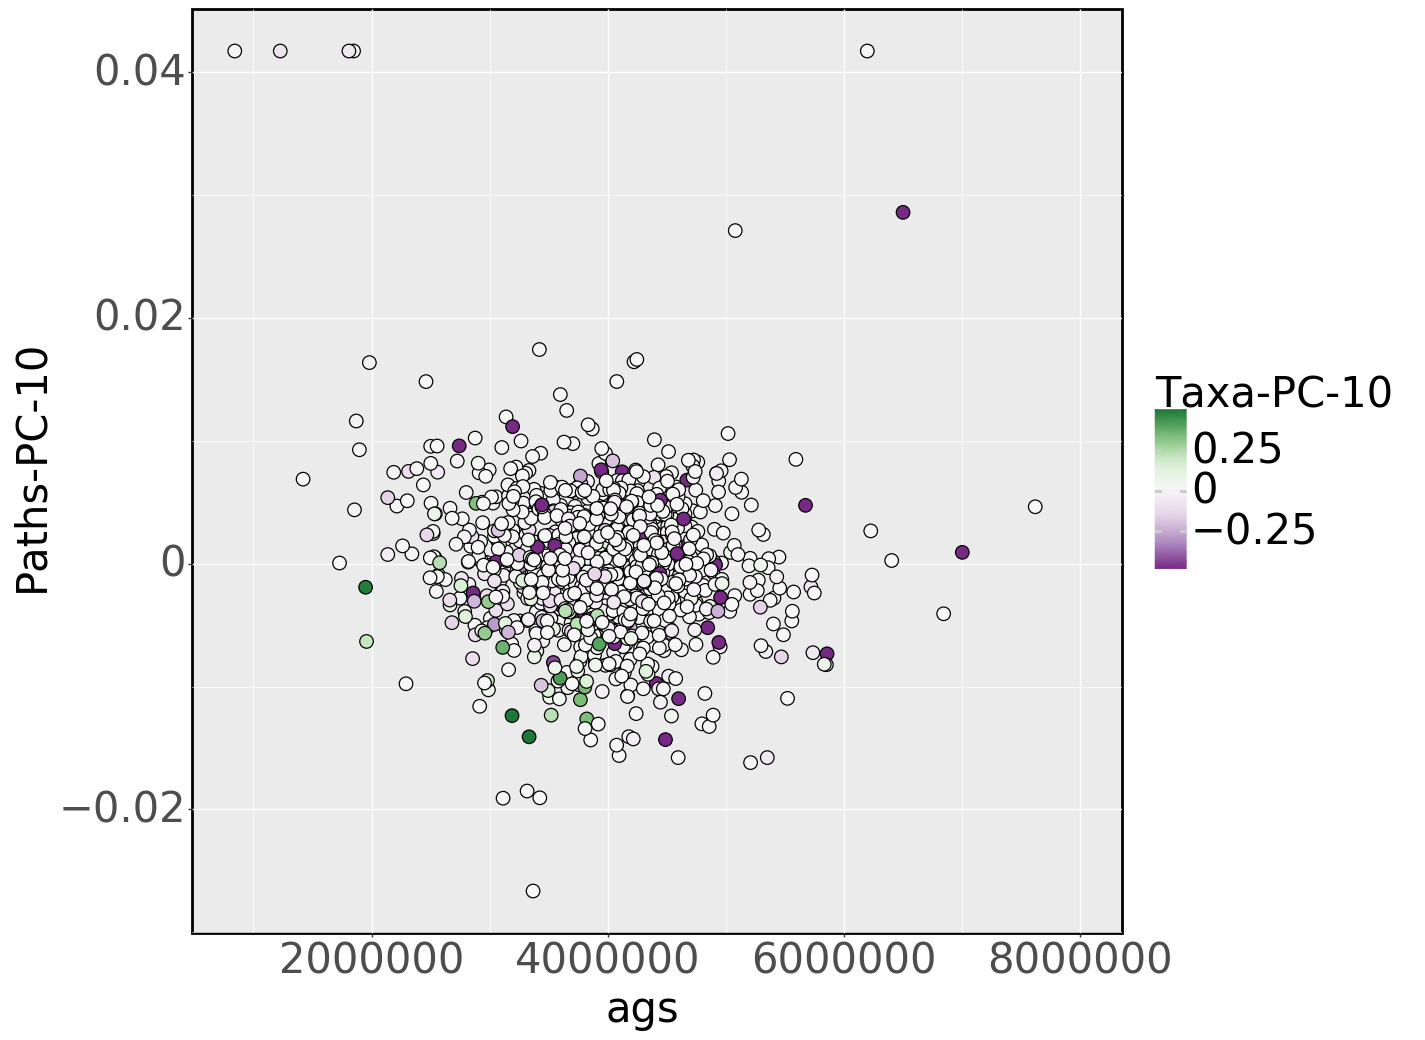

<ggplot: (8764557574334)>

In [160]:
scatter(pca_comb, 'ags', 'Paths-PC-10', 'Taxa-PC-10') + xlim(None, 8e6)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 149 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


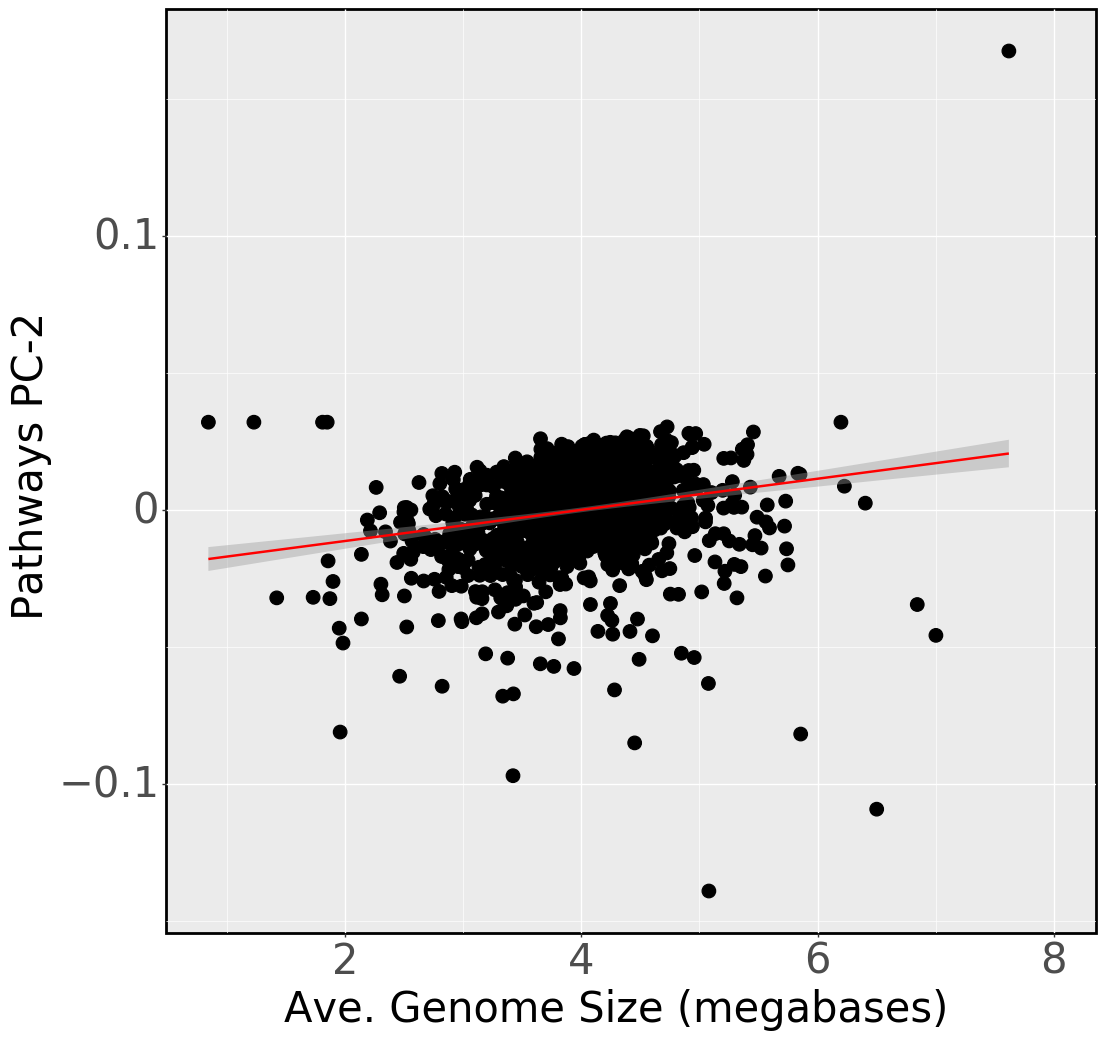

<ggplot: (-9223363272343216682)>

In [226]:
tbl = pca_comb.copy()
tbl['ags'] = tbl['ags'].map(lambda x: x / 1000000)

(
    ggplot(tbl, aes(x='ags', y='Paths-PC-2')) +
        geom_point(size=5, color='black') +
        #theme_minimal() +
        ylab('Pathways PC-2') +
        xlab('Ave. Genome Size (megabases)') +
        scale_fill_distiller(palette=2, type='div') +
        xlim(None, 8) +
        geom_smooth(color='red') +
        theme(
            text=element_text(size=30),
            figure_size=(12, 12),
            #legend_position='none',
            #axis_text_x=element_text(angle=90),
            panel_border=element_rect(colour="black", fill='none', size=2),
        )
)

In [169]:
comb = pd.concat([
    ags,
    umap(p, n_components=1, col_prefix='PATHS-', n_neighbors=10, metric='manhattan'),
    umap(t, n_components=1, col_prefix='TAXA-', n_neighbors=10, metric='manhattan'),

], axis=1)
comb.columns = ['ags'] + list(comb.columns[1:])
comb['log_ags'] = comb['ags'].map(lambda x: log10(min(x, 1e7)))
comb['cat_ags'] = comb['ags'].map(lambda x: int(x < comb['ags'].median()))
comb

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ags,PATHS-C0,TAXA-C0,log_ags,cat_ags
PATHOMAP_AB001,2.521356e+06,12.009221,2.054895,6.401634,1
PATHOMAP_AB002,3.653614e+06,1.160564,-7.175107,6.562723,1
PATHOMAP_AB003,5.337981e+06,24.001398,-11.252603,6.727377,0
PATHOMAP_AB004,5.558052e+06,12.199080,-6.455497,6.744923,0
PATHOMAP_AB005,4.245577e+06,10.992345,1.695714,6.627937,0
...,...,...,...,...,...
PATHOMAP_P01612,1.323510e+07,4.725038,-8.595547,7.000000,0
PATHOMAP_P01613,4.307745e+06,5.583721,-11.188719,6.634250,0
PATHOMAP_PosControl_NARG1,3.514341e+06,-6.215152,-12.367903,6.545844,1
PATHOMAP_PosControl_NARG2,3.200979e+06,-6.200699,-12.417972,6.505283,1


/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 149 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


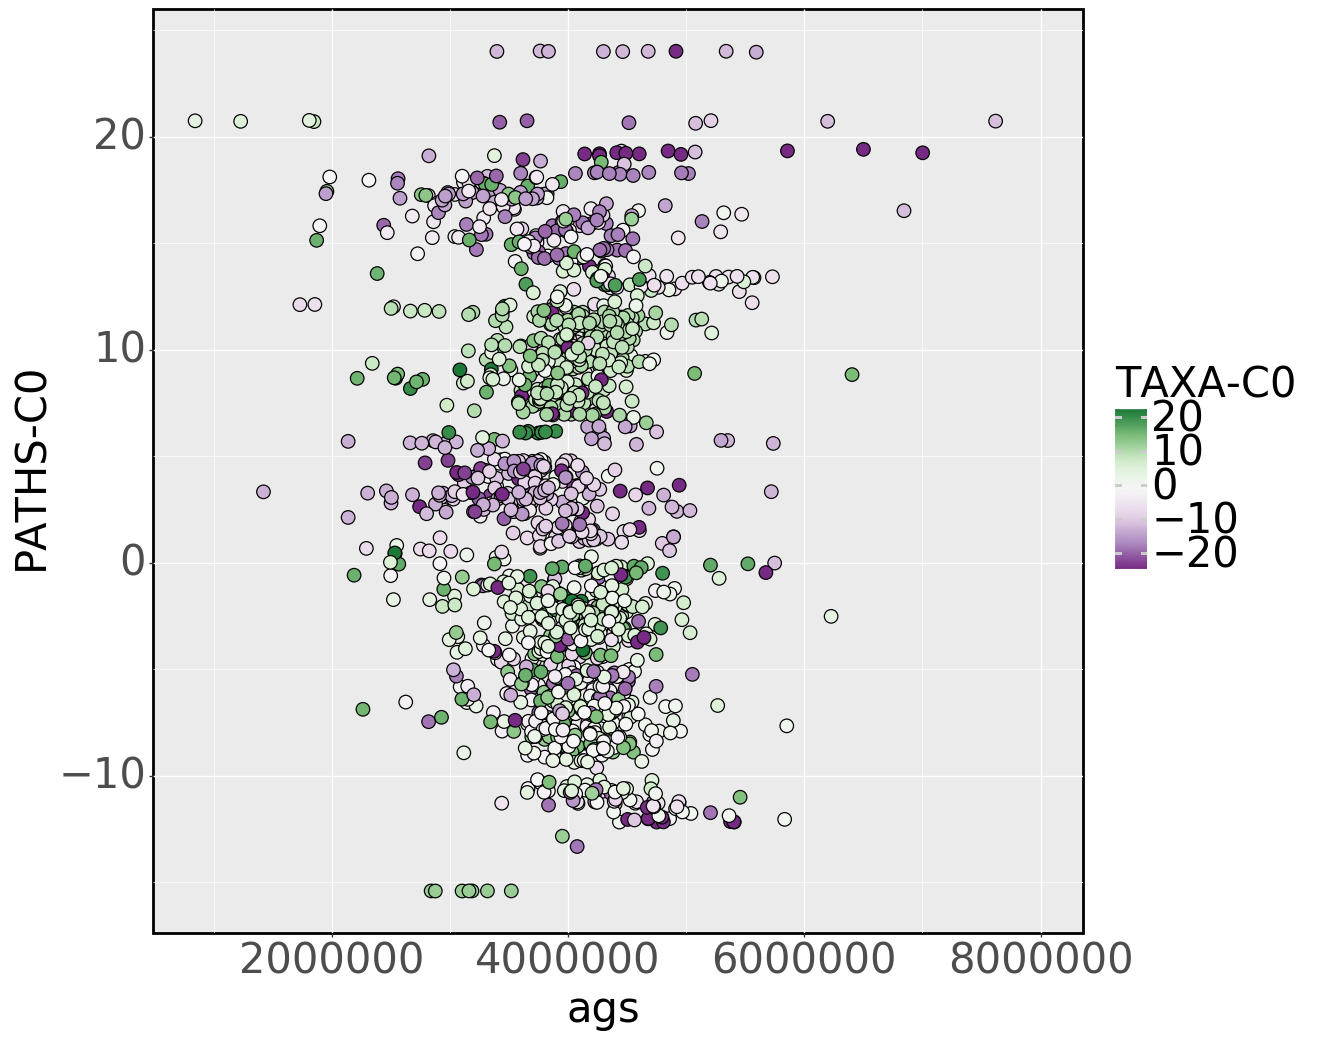

<ggplot: (-9223363272302111267)>

In [172]:
scatter(comb, 'ags', 'PATHS-C0', 'TAXA-C0') + xlim(None, 8e6)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/dcdanko/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 195 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


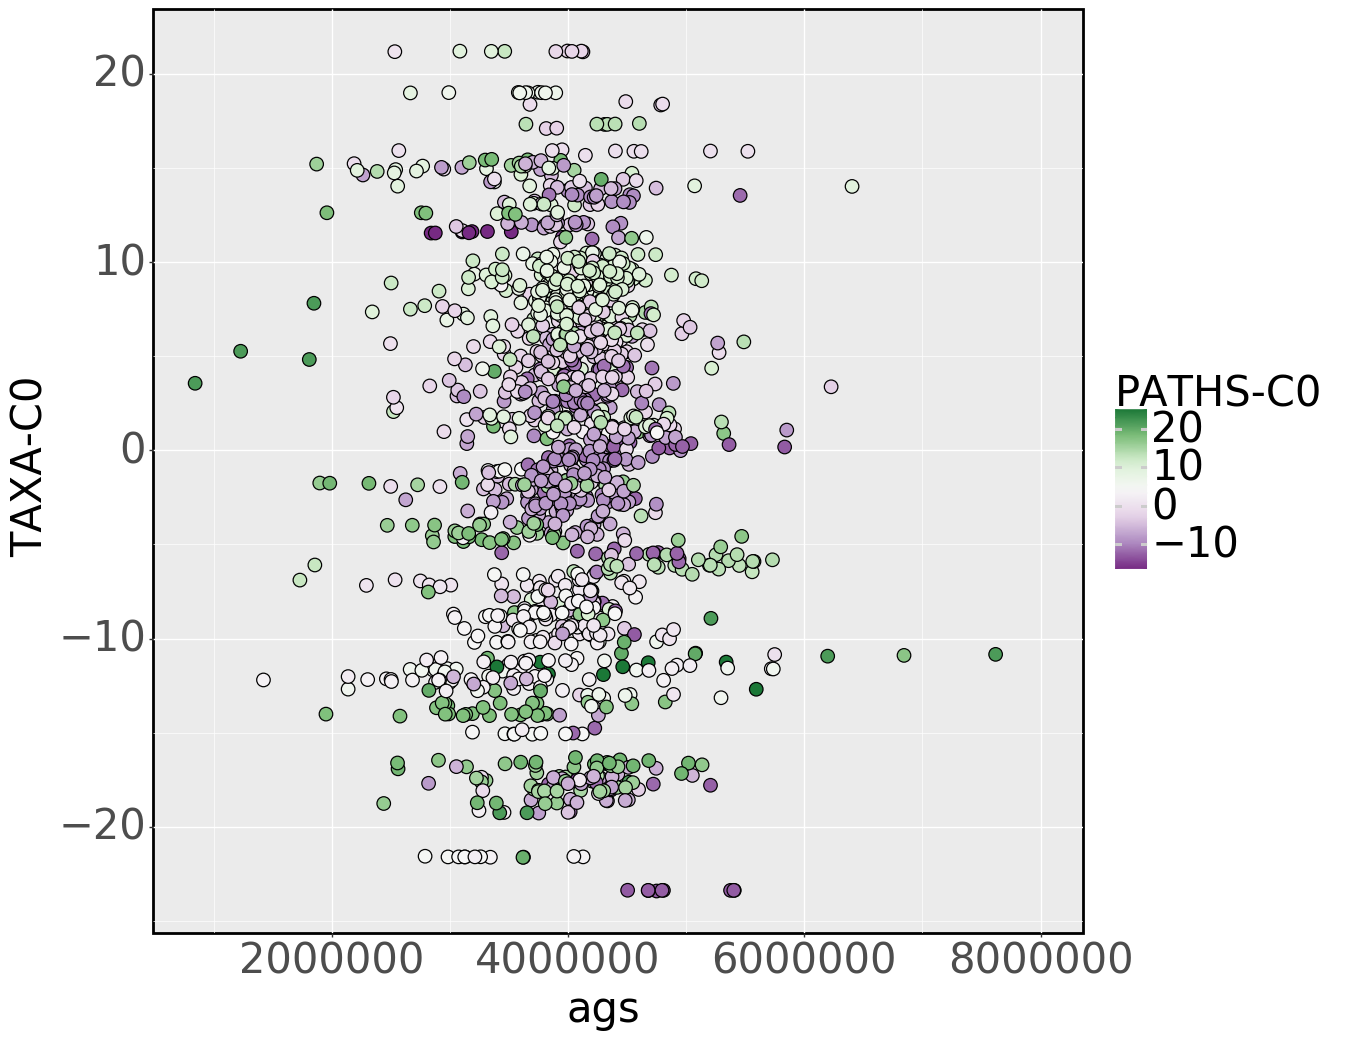

<ggplot: (8764529827788)>

In [173]:
scatter(comb, 'ags', 'TAXA-C0', 'PATHS-C0') + xlim(None, 8e6)

In [178]:
def entropy(row):
    

PATHOMAP_AB001               2644
PATHOMAP_AB002               1698
PATHOMAP_AB003               1733
PATHOMAP_AB004               2242
PATHOMAP_AB005               3687
                             ... 
PATHOMAP_P01611              2703
PATHOMAP_P01612              5893
PATHOMAP_P01613              4699
PATHOMAP_PosControl_NARG1     627
PATHOMAP_PosControl_NARG2     816
Length: 1521, dtype: int64

In [209]:
virs = set([c for c in taxa.columns if 'virus' in c.lower()])
virs &= set(taxa.columns)
virs = taxa[virs]
virs = (virs.T / taxa.sum(axis=1)).T


a = ags.copy()
a.columns = ['ags']
a['rich'] = (t > 0).sum(axis=1)
a['entropy'] = t.apply(shannon_entropy, axis=1)
a['vir'] = virs.sum(axis=1)
a['vir_rich'] = (virs > 0).sum(axis=1)

a.corr(method='spearman')

,ags,rich,entropy,vir,vir_rich
ags,1.000000,-0.059001,-0.069698,0.076117,-0.102382
rich,-0.059001,1.000000,0.598799,0.254503,0.573833
entropy,-0.069698,0.598799,1.000000,0.321644,0.412181
vir,0.076117,0.254503,0.321644,1.000000,0.400199
vir_rich,-0.102382,0.573833,0.412181,0.400199,1.000000


/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 56 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


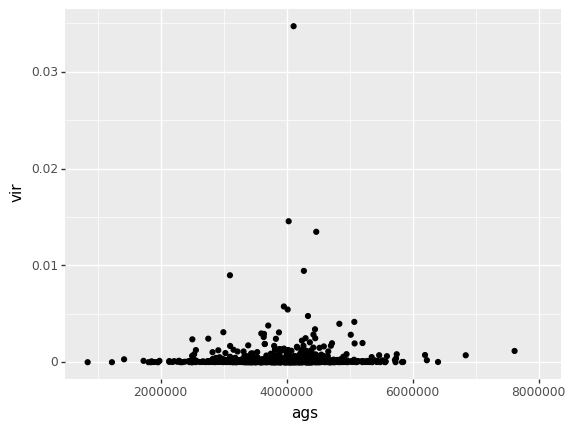

<ggplot: (8764561623928)>

In [210]:
(
    ggplot(a, aes(x='ags', y='vir')) +
        geom_point() +
        xlim(None, 8e6)
)

In [215]:
virs.fillna(0).sum(axis=1)

PATHOMAP_AB001               0.000258
PATHOMAP_AB002               0.001874
PATHOMAP_AB003               0.000089
PATHOMAP_AB004               0.000034
PATHOMAP_AB005               0.000383
                               ...   
PATHOMAP_P01611              0.000075
PATHOMAP_P01612              0.001295
PATHOMAP_P01613              0.001196
PATHOMAP_PosControl_NARG1    0.000002
PATHOMAP_PosControl_NARG2    0.000004
Length: 1521, dtype: float64